In [21]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from transformers import BertTokenizer, BertConfig
from transformers.modeling_outputs import SequenceClassifierOutput
from transformers import BertPreTrainedModel, BertModel
from tqdm import tqdm
import os
import safetensors.torch as st
import matplotlib.pyplot as plt

In [22]:
# Model definition (copied from main.py)
class SmallerBERTClassifier(BertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.bert = BertModel(config)
        self.dropout = nn.Dropout(0.4)
        self.classifier = nn.Sequential(
            nn.Linear(config.hidden_size, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, config.num_labels)
        )

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        pooled = self.dropout(outputs.pooler_output)
        logits = self.classifier(pooled)
        return SequenceClassifierOutput(
            loss=None,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions
        )

# Paths
MODEL_DIR = "saved_liar_bert_model"
WEIGHTS_PATH = os.path.join(MODEL_DIR, "model.safetensors")
TSV_PATH = "../../LIAR-PLUS-master/dataset/tsv/train2.tsv"
OUTPUT_CSV = "train2_preds.csv"

# Load tokenizer and model
tokenizer = BertTokenizer.from_pretrained(MODEL_DIR)
config = BertConfig.from_pretrained(MODEL_DIR)
model = SmallerBERTClassifier(config)

# Load weights from safetensors
state_dict = st.load_file(WEIGHTS_PATH)
model.load_state_dict(state_dict)
model.eval()

SmallerBERTClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, ele

In [122]:
import numpy as np

# statement = df_val["statement"].iloc[idx]
statement = "California is a state with many people."
# statement = "Mitt Romney once supported President Obamas health care plan but now opposes it."
print(statement)
# print(df_val["label"].iloc[idx])
justification = ""

# Ensure both are strings and handle NaN
if not isinstance(statement, str):
    statement = "" if pd.isna(statement) else str(statement)
if not isinstance(justification, str):
    justification = "" if pd.isna(justification) else str(justification)

# Tokenize as in main.py
inputs = tokenizer(
    statement,
    justification,
    return_tensors="pt",
    truncation=True,
    padding=True,
    max_length=256
)

with torch.no_grad():
    outputs = model(**inputs)
    probs = torch.softmax(outputs.logits, dim=1).squeeze()
    # Lower the threshold for "misinfo" to prioritize recall
    threshold = 0.35  # adjust this value as needed
    if probs[1] >= threshold:
        prediction = 1
    else:
        prediction = 0
    confidence = probs[prediction].item()
    misinfo_prob = probs[1].item() # equals confidence if prediction == 1 otherwise equals 1 - confidence

print(prediction, misinfo_prob)

California is a state with many people.
0 0.3182004690170288


In [119]:
pd.set_option('display.max_colwidth', None)

from IPython.display import display, HTML

# Filter rows where label is "misinfo" and prediction is "misinfo"
filtered_df = df_val

html = filtered_df[["statement", "col2", "label", "prediction", "misinfo_prob"]].to_html(max_rows=None)
display(HTML(f'<div style="max-height: 400px; overflow-y: auto">{html}</div>'))

,statement,col2,label,prediction,misinfo_prob
0,We have less Americans working now than in the 70s.,barely-true,misinfo,not misinfo,0.2611
1,"When Obama was sworn into office, he DID NOT use the Holy Bible, but instead the Kuran (Their equivalency to our Bible, but very different beliefs).",pants-fire,misinfo,misinfo,0.5132
2,Says Having organizations parading as being social welfare organizations and then being involved in the political combat harkens back to why the statute a hundred years ago said that they were prohibited.,false,misinfo,misinfo,0.5036
3,Says nearly half of Oregons children are poor.,half-true,not misinfo,not misinfo,0.2728
4,"On attacks by Republicans that various programs in the economic stimulus plan are not stimulative, ""If you add all that stuff up, it accounts for less than 1 percent of the overall package.""",half-true,not misinfo,misinfo,0.3514
5,"Says when armed civilians stop mass shootings with guns, an average of 2.5 people die; otherwise, an average of 18 people die.",false,misinfo,not misinfo,0.2572
6,Says Tennessee is providing millions of dollars to virtual school company for results at the bottom of the bottom.,true,not misinfo,misinfo,0.5722
7,"The health care reform plan would set limits similar to the socialized system in Britain, where people are allowed to die if their treatment would cost more than $22,000.",false,misinfo,misinfo,0.3886
8,Says Donald Trump started his career back in 1973 being sued by the Justice Department for racial discrimination because he would not rent apartments in one of his developments to African-Americans.,true,not misinfo,misinfo,0.4538
9,Bill White has a long history of trying to limit or even disenfranchise military voters.,half-true,not misinfo,misinfo,0.4775


In [23]:
df_val = pd.read_csv("val2_preds.csv")
df_train = pd.read_csv("train2_preds.csv")
df_test = pd.read_csv("test2_preds.csv")

In [26]:
misinfo_labels = ["pants-fire", "false", "barely-true"]
not_misinfo_labels = ["half-true", "mostly-true", "true"]

def assign_label(row):
    if row["col2"] in misinfo_labels:
        return "misinfo"
    elif row["col2"] in not_misinfo_labels:
        return "not misinfo"
    else:
        return None

for df_name in ["df_train", "df_val", "df_test"]:
    df_obj = globals()[df_name]
    df_obj["label"] = df_obj.apply(assign_label, axis=1)

In [6]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score

def print_metrics(df, name):
    y_true = (df["label"] == "misinfo").astype(int)
    y_pred = (df["prediction"] == "misinfo").astype(int)
    cm = confusion_matrix(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    print(f"=== {name} ===")
    print("Confusion Matrix:")
    print(cm)
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"F1 Score:  {f1:.4f}\n")

print_metrics(df_train, "Train")
print_metrics(df_val, "Validation")
print_metrics(df_test, "Test")

=== Train ===
Confusion Matrix:
[[4090 1664]
 [1193 3295]]
Precision: 0.6644
Recall:    0.7342
Accuracy:  0.7211
F1 Score:  0.6976

=== Validation ===
Confusion Matrix:
[[461 207]
 [277 339]]
Precision: 0.6209
Recall:    0.5503
Accuracy:  0.6231
F1 Score:  0.5835

=== Test ===
Confusion Matrix:
[[479 235]
 [245 308]]
Precision: 0.5672
Recall:    0.5570
Accuracy:  0.6212
F1 Score:  0.5620



In [27]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score

def print_metrics(df, name):
    y_true = (df["label"] == "misinfo").astype(int)
    y_pred = (df["prediction"] == "misinfo").astype(int)
    cm = confusion_matrix(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    print(f"=== {name} ===")
    print("Confusion Matrix:")
    print(cm)
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"F1 Score:  {f1:.4f}\n")

print_metrics(df_train, "Train")
print_metrics(df_val, "Validation")
print_metrics(df_test, "Test")

=== Train ===
Confusion Matrix:
[[4839  915]
 [2247 2241]]
Precision: 0.7101
Recall:    0.4993
Accuracy:  0.6913
F1 Score:  0.5863

=== Validation ===
Confusion Matrix:
[[527 141]
 [344 272]]
Precision: 0.6586
Recall:    0.4416
Accuracy:  0.6223
F1 Score:  0.5287

=== Test ===
Confusion Matrix:
[[578 136]
 [330 223]]
Precision: 0.6212
Recall:    0.4033
Accuracy:  0.6322
F1 Score:  0.4890



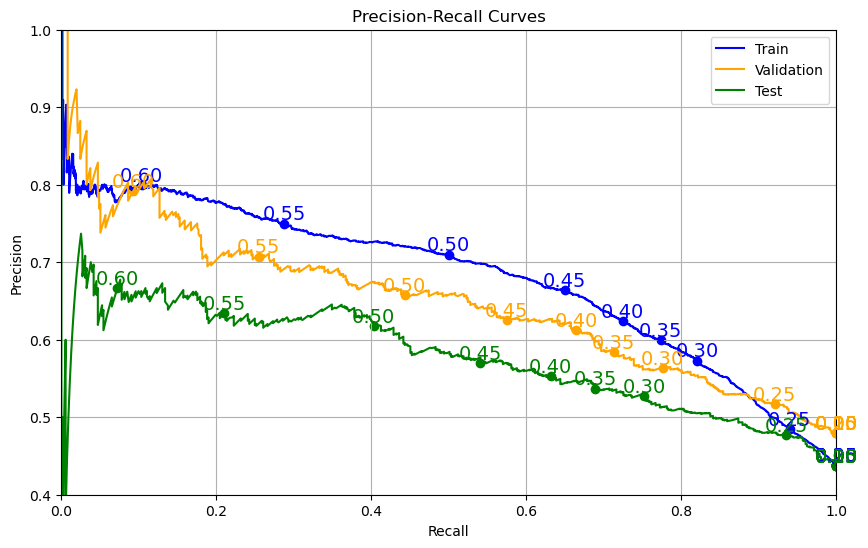

In [125]:
from sklearn.metrics import precision_recall_curve, f1_score
import numpy as np
import matplotlib.pyplot as plt

# Prepare data for all splits
splits = {
    "Train": ((df_train["label"] == "misinfo").astype(int), df_train["misinfo_prob"]),
    "Validation": ((df_val["label"] == "misinfo").astype(int), df_val["misinfo_prob"]),
    "Test": ((df_test["label"] == "misinfo").astype(int), df_test["misinfo_prob"])
}

plt.figure(figsize=(10, 7))

colors = {"Train": "blue", "Validation": "orange", "Test": "green"}

for name, (y_true, y_scores) in splits.items():
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    thresholds = np.append(thresholds, 1.0)
    precision = np.append(precision, precision[-1])
    recall = np.append(recall, recall[-1])
    plt.plot(recall, precision, label=name, color=colors[name])

    # Annotate thresholds with threshold and F1 score
    for t in np.arange(0, 0.65, 0.05):
        idx = np.argmin(np.abs(thresholds - t))
        # Compute F1 at this threshold
        y_pred = (y_scores >= thresholds[idx]).astype(int)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        plt.scatter(recall[idx], precision[idx], color=colors[name])
        plt.text(
            recall[idx], precision[idx],
            # f"{t:.2f}\nF1:{f1:.2f}",
            f"{t:.2f}",
            color=colors[name], fontsize=14, ha='center', va='bottom'
        )

plt.xlabel("Recall")
plt.xlim(0, 1)
plt.ylim(0.4, 1)
plt.ylabel("Precision")
plt.title("Precision-Recall Curves")
plt.legend()
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [30]:
# Apply new threshold of 0.35 for "misinfo" prediction
def apply_threshold(df, threshold=0.35):
    return np.where(df["misinfo_prob"] >= threshold, "misinfo", "not misinfo")

df_train["prediction"] = apply_threshold(df_train, 0.35)
df_val["prediction"] = apply_threshold(df_val, 0.35)
df_test["prediction"] = apply_threshold(df_test, 0.35)

print_metrics(df_train, "Train (thresh=0.35)")
print_metrics(df_val, "Validation (thresh=0.35)")
print_metrics(df_test, "Test (thresh=0.35)")

=== Train (thresh=0.35) ===
Confusion Matrix:
[[3437 2317]
 [1018 3470]]
Precision: 0.5996
Recall:    0.7732
Accuracy:  0.6744
F1 Score:  0.6754

=== Validation (thresh=0.35) ===
Confusion Matrix:
[[356 312]
 [177 439]]
Precision: 0.5846
Recall:    0.7127
Accuracy:  0.6192
F1 Score:  0.6423

=== Test (thresh=0.35) ===
Confusion Matrix:
[[386 328]
 [172 381]]
Precision: 0.5374
Recall:    0.6890
Accuracy:  0.6054
F1 Score:  0.6038

